In [1]:
# importing necessary libraries
import numpy as np
import math
import matplotlib.pyplot as plt

import os
import sys
import random

import skimage.io as io
import pylab

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
from torch.nn.utils.rnn import pack_padded_sequence
import torch.utils.data as data

import nltk
import time

import git
from git import Repo

from collections import Counter
import requests

%matplotlib inline
# sys.path.append('/home/dnn/Storage8TB/pythonCodeArea/Alfahad/PythonAPI3/home')
# sys.path.insert(0,'/home/dnn/Storage8TB/pythonCodeArea/Alfahad/PythonAPI1/advanced/image-captioning')
sys.path.insert(0,'/home/dnn/Storage8TB/pythonCodeArea/Alfahad/PythonAPI3/home')
# sys.path.append('./coco_ann')
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
from data_loader import get_loader
from coco import COCO
# from model import EncoderCNN, DecoderRNN

In [3]:
datadir='./COCO'
datatype='val2014'
captions_ann_file=os.path.join(datadir,'annotations/captions_{}.json'.format(datatype))
instances_ann_file=os.path.join(datadir,'annotations/instances_{}.json'.format(datatype))
coco=COCO(instances_ann_file)
coco_caps=COCO(captions_ann_file)
ids=list(coco.anns.keys())

loading annotations into memory...
Done (t=3.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


http://images.cocodataset.org/val2014/COCO_val2014_000000469088.jpg


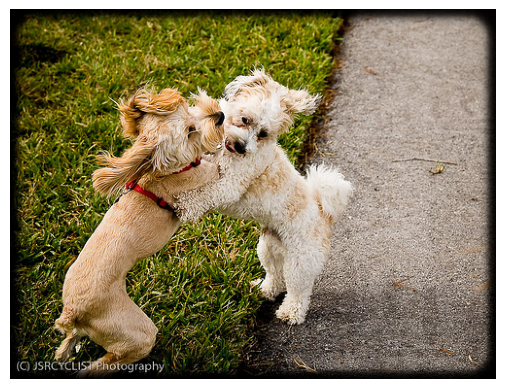

Two dogs that are standing up holding each other.
Two dogs on their hind legs playing with each other.
Two dogs standing on their back legs wrestling with one another.
Two little, well groomed dogs hugging each other energetically
A couple of dogs standing each other up being playful.


In [4]:
# selecting a random image and getting its url
ann_id=np.random.choice(ids)
img_id=coco.anns[ann_id]['image_id']
img=coco.loadImgs(img_id)[0]
url=img['coco_url']

#displaying the image and url
print(url)
I=io.imread(url)
plt.imshow(I)
plt.axis('off')
plt.show()

#displaying captions
annIds=coco_caps.getAnnIds(imgIds=img['id'])
anns=coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [5]:
# values of the variables

vocab_threshold=5  # minimum word count threshold
batch_size=8
vocab_from_file=True # if true, load existing vocab file
embed_size=256 # dimension of image and word embedding
hidden_size=512 # hiddem size of RNN part
num_epochs=1
save_every=1 # freq of saving the model weights
print_every=100
log_file='training_log_file_2.txt'

# composing the transformations of the image (preprocessing training images)

transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# data loader obtaining
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████| 414113/414113 [00:26<00:00, 15614.75it/s]


In [6]:
# preprocessing captions before feeding it to the model
sample_caption='A man riding a skateboard down a curvy road.'
sample_tokens=nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)

['a', 'man', 'riding', 'a', 'skateboard', 'down', 'a', 'curvy', 'road', '.']


In [7]:
sample_caption=[]
start_word=data_loader.dataset.vocab.start_word
print('special start word: ',start_word)
sample_caption.append(data_loader.dataset.vocab(start_word))
print(sample_caption)

special start word:  <start>
[0]


In [8]:
sample_caption.extend([data_loader.dataset.vocab(token) for token in sample_tokens])
print(sample_caption)

[0, 3, 169, 139, 3, 753, 54, 3, 5099, 40, 18]


In [9]:
end_word=data_loader.dataset.vocab.end_word
print('special end word: ',end_word)
print(data_loader.dataset.vocab(end_word))
sample_caption.append(data_loader.dataset.vocab(end_word))
print(sample_caption)

special end word:  <end>
1
[0, 3, 169, 139, 3, 753, 54, 3, 5099, 40, 18, 1]


In [10]:
unk_word=data_loader.dataset.vocab.unk_word
print('special unknown word: ',unk_word)
sample_caption.append(data_loader.dataset.vocab(unk_word))
print(sample_caption)

special unknown word:  <unk>
[0, 3, 169, 139, 3, 753, 54, 3, 5099, 40, 18, 1, 2]


In [11]:
print('total number of tokens in the vocabulary--',len(data_loader.dataset.vocab)) #for threshold 5

total number of tokens in the vocabulary-- 8852


In [12]:
dict(list(data_loader.dataset.vocab.word2idx.items())[:10])

{'<start>': 0,
 '<end>': 1,
 '<unk>': 2,
 'a': 3,
 'very': 4,
 'clean': 5,
 'and': 6,
 'well': 7,
 'decorated': 8,
 'empty': 9}

In [13]:
# modifying vocab threshold and 
vocab_threshold=4  # minimum word count threshold

data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)
print('toal number of tokens--',len(data_loader.dataset.vocab))

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████| 414113/414113 [00:26<00:00, 15815.03it/s]


toal number of tokens-- 9947


In [14]:
#saving the new vocabulary to file,and loading the new vocabulary
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_from_file=True)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████| 414113/414113 [00:26<00:00, 15509.82it/s]


In [15]:
#number of caption with the caption_length is shown below, mejority has length 10
counter=Counter(data_loader.dataset.caption_lengths)
lengths=sorted(counter.items(),key=lambda pair: pair[1], reverse=True)
print('Total count of training captions with its length value')
for value,count in lengths:
    print('value: %2d ----- count: %5d'% (value,count))

Total count of training captions with its length value
value: 10 ----- count: 86302
value: 11 ----- count: 79971
value:  9 ----- count: 71920
value: 12 ----- count: 57653
value: 13 ----- count: 37668
value: 14 ----- count: 22342
value:  8 ----- count: 20742
value: 15 ----- count: 12839
value: 16 ----- count:  7736
value: 17 ----- count:  4845
value: 18 ----- count:  3101
value: 19 ----- count:  2017
value:  7 ----- count:  1594
value: 20 ----- count:  1453
value: 21 ----- count:   997
value: 22 ----- count:   683
value: 23 ----- count:   534
value: 24 ----- count:   384
value: 25 ----- count:   277
value: 26 ----- count:   214
value: 27 ----- count:   160
value: 28 ----- count:   114
value: 29 ----- count:    87
value: 30 ----- count:    58
value: 31 ----- count:    49
value: 32 ----- count:    44
value: 34 ----- count:    40
value: 37 ----- count:    32
value: 35 ----- count:    31
value: 33 ----- count:    30
value: 36 ----- count:    26
value: 38 ----- count:    18
value: 39 ----- c

In [16]:
# randomly pick a sample length along with its indices
indices=data_loader.dataset.get_train_indices()
print('sampled indices--',indices)

# assigning a batch sampler to get a batch with the sample indices
new_sampler=data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler=new_sampler

# Get the batch
images,captions=next(iter(data_loader))

print('ímages shape: ',images.shape)
print('captions shape: ',captions.shape)

sampled indices-- [332554, 167652, 155745, 81563, 203011, 344900, 320443, 84822]
ímages shape:  torch.Size([8, 3, 224, 224])
captions shape:  torch.Size([8, 12])


In [21]:
# encoder decoder model

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        
        # pretrained model resnet50
        resnet = models.resnet101(pretrained=True)
        
        # we don't want to train the resnet itself
        for param in resnet.parameters():
            param.requires_grad_(False)
            
        ''' removing the final fully connected layers to extract features from the images,
        final fc layer being the output classification layer '''
        modules = list(resnet.children())[:-1]

        '''he forward() method of Sequential accepts any input and forwards it to the first module it contains. 
        It then “chains” outputs to inputs sequentially for each subsequent module, 
        finally returning the output of the last module.'''
        self.resnet = nn.Sequential(*modules)
        # replace the classifier with a fully connected embedding layer

        # linear transformation from features to embed size
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features
    

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        
        super(DecoderRNN, self).__init__()
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        '''word embedding is used to represent words in lower dimension numeric vectors, than the one hot encoding.
         so that similar words have similar representations. Embedding will be learned through training process'''
        self.word_embedding = nn.Embedding(self.vocab_size, self.embed_size)

        # Applying LSTM
        self.lstm = nn.LSTM(self.embed_size, 
                            self.hidden_size, 
                            self.num_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(self.hidden_size, self.vocab_size)
        # self.hidden = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
        
    
    def forward(self, features, captions):
        
        caption_embed = self.word_embedding(captions[:, :-1])

        '''unsqueeze is used to change the dimension of tensor.
        cat is used to concatenate the given sequence of seq tensors in the given dimension'''
        
        caption_embed = torch.cat((features.unsqueeze(dim=1), caption_embed),1)
        output, self.hidden = self.lstm(caption_embed)
        # print(output.shape)
        output = self.fc(output)
        # print(self.embed_size, self.vocab_size)
        return output

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len)"
        """Samples captions for given image features."""
        output = []
        (h, c) = (torch.randn(self.num_layers, 1, self.hidden_size).to(inputs.device), 
                  torch.randn(self.num_layers, 1, self.hidden_size).to(inputs.device))
        
        for i in range(max_len):
            x, (h, c) = self.lstm(inputs, (h, c)) # X is lstm output
            x = self.fc(x)
            x = x.squeeze(1)
            predict = x.argmax(dim=1)
            if predict.item() == 1: # 1 is stop index
                break
            output.append(predict.item())
            inputs = self.word_embedding(predict.unsqueeze(0))
        return output

In [22]:
# the preprocessed images are passed through the encoder to obtain the features
# Specify the dimensionality of the image embedding.

embed_size = 256

# Initialize the encoder 
encoder = EncoderCNN(embed_size)

# Move the encoder to GPU if CUDA is available.
encoder.to(device)
    
# Move last batch of images to GPU if CUDA is available.   
images = images.to(device)

# Pass the images through the encoder.
features = encoder(images)

print('type(features):', type(features))
print('features.shape:', features.shape)

assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor." 
assert (features.shape[0]==batch_size) & (features.shape[1]==embed_size), "The shape of the encoder output is incorrect."

/home/dnn/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dnn/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/dnn/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|████████████████████████████████████████| 171M/171M [00:24<00:00, 7.29MB/s]


type(features): <class 'torch.Tensor'>
features.shape: torch.Size([8, 256])


In [23]:
# the image features obtained through encoder are passed through the decoder to obtain the captions
# Specify the number of features fo the hidden size of the decoder
hidden_size=512

# store the size of the vocabulary
vocab_size=len(data_loader.dataset.vocab)

# Initialize the decoder
decoder = DecoderRNN(embed_size,hidden_size,vocab_size)

# Move the decoder to GPU
decoder.to(device)
    
# Move last batch of captions to GPU   
captions = captions.to(device)

# Pass the encoder output and captions through decoder
outputs = decoder(features,captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)

# Check that your encoder satisfies some requirements of the project
assert type(outputs)==torch.Tensor, "Decoder output needs to be a PyTorch Tensor."
assert (outputs.shape[0]==batch_size) & (outputs.shape[1]==captions.shape[1]) & (outputs.shape[2]==vocab_size), "The shape of the decoder output is incorrect."

type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([8, 12, 9947])


In [24]:
#training setup

batch_size=8
vocab_threshold=4
vocab_from_file=True
embed_size=256
hidden_size=512
num_epochs=3
save_every=1
print_every=100
log_file='./PythonAPI3/home/training_log_file_2.txt'

#image transformations
transform_train=transforms.Compose([transforms.Resize(256),transforms.RandomCrop(224),
                                   transforms.RandomHorizontalFlip(),transforms.ToTensor(),
                                   transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))])

#Build the dataloader
data_loader=get_loader(transform=transform_train,mode='train'
                      ,batch_size=batch_size,vocab_from_file=vocab_from_file,vocab_threshold=vocab_threshold)

vocab_size=len(data_loader.dataset.vocab)
encoder=EncoderCNN(embed_size)
decoder=DecoderRNN(embed_size,hidden_size,vocab_size)
encoder.to(device)
decoder.to(device)

# define the loss function
criterion=nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

#specify the learnable parameters of the model
params=list(decoder.parameters())+list(encoder.embed.parameters())

#define the optimizer
optimizer=torch.optim.Adam(params,lr=0.001)

#set the total number of training steps per epoch
total_step=math.ceil(len(data_loader.dataset.caption_lengths)/data_loader.batch_sampler.batch_size)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████| 414113/414113 [00:26<00:00, 15608.00it/s]


In [25]:
# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./PythonAPI3/home/models_2', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./PythonAPI3/home/models_2', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

Epoch [1/3], Step [100/51765], Loss: 4.2892, Perplexity: 72.9078
Epoch [1/3], Step [200/51765], Loss: 4.2665, Perplexity: 71.27241
Epoch [1/3], Step [300/51765], Loss: 3.2010, Perplexity: 24.55631
Epoch [1/3], Step [400/51765], Loss: 3.8207, Perplexity: 45.63477
Epoch [1/3], Step [500/51765], Loss: 3.8928, Perplexity: 49.04980
Epoch [1/3], Step [600/51765], Loss: 3.6512, Perplexity: 38.5192
Epoch [1/3], Step [700/51765], Loss: 4.4390, Perplexity: 84.6898
Epoch [1/3], Step [800/51765], Loss: 3.4292, Perplexity: 30.85169
Epoch [1/3], Step [900/51765], Loss: 3.3688, Perplexity: 29.04450
Epoch [1/3], Step [1000/51765], Loss: 3.7733, Perplexity: 43.5230
Epoch [1/3], Step [1100/51765], Loss: 3.4671, Perplexity: 32.04450
Epoch [1/3], Step [1200/51765], Loss: 2.9221, Perplexity: 18.57963
Epoch [1/3], Step [1300/51765], Loss: 3.0102, Perplexity: 20.29240
Epoch [1/3], Step [1400/51765], Loss: 3.5131, Perplexity: 33.5520
Epoch [1/3], Step [1500/51765], Loss: 3.2570, Perplexity: 25.9720
Epoch [1/3